# Change point detection

Given a word (o set thereof), calculate the cosine similarity between its vector in the most recent time slice and each of the previous timeslices, and automatically detect significant changepoints. To detect changepoints we will use the [PELT algorithm](https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/), as implemented in the [`ruptures`](https://centre-borelli.github.io/ruptures-docs/) library.

It goes without saying but, before starting, make sure you have trained and aligned diachronic embedding models.

In [ ]:
import os
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from statistics import mean
from tqdm import tqdm
from glob import glob
from scipy import spatial
import csv
from matplotlib import pyplot as plt
import ruptures as rpt

Create subdir for all outputs of this notebook if it does not exist already:

In [2]:
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

### Load pre-trained diachronic embeddings

Change the following to the path to the folder containing the aligned diachonic models:

In [3]:
pathtomodels = '../../outputs/lwmhmdwhole/aligned'

List all models in the folder and sort them (so that we can identify the most recent time slice):

In [4]:
allmodels = sorted(glob(f'{pathtomodels}/*.model'))

Load the model for the most recent time slice:

In [5]:
lastmodel = Word2Vec.load(allmodels[-1])

Get the 'name' of each time slice (retrieved from the name of the model):

In [6]:
slices_names = []
for i in range(len(allmodels)):
    slice_name = allmodels[i].split('/')[-1].split('.model')[0]
    slices_names.append(slice_name)

### Define words to analyse

Give a list of words you wish to submit to the changepoint detection analysis (it can be one word only):

In [7]:
words = ['machine','traffic','train','coach','wheel','fellow','railway','match']

Define function for calculating cosine similarity:

In [8]:
def cosine_similarity(word,modelx,modely):
  sc = 1-spatial.distance.cosine(modelx.wv[word], modely.wv[word])
  return sc

Iterate over all words and for each word iterate over each decade. Calculate cossim between the vector of the same word in the last time slice and each of the previous time slices. Write the list of cosine similarity scores under the relevant column:

In [9]:
cosmatrix = []
columns = ['timeslice'] + words
df = pd.DataFrame(columns=columns)
df['timeslice'] = slices_names
for word in words:
    print(f'Now processing {word}')
    col = []
    for i in range(len(allmodels)):
        prevmodel = Word2Vec.load(allmodels[i])
        try:
            col.append(cosine_similarity(word,prevmodel,lastmodel))
        except KeyError:
            col.append('key_not_present')
    df[word] = col

Now processing machine
Now processing traffic
Now processing train
Now processing coach
Now processing wheel
Now processing fellow
Now processing railway
Now processing match


If you wish, you can save the `df`:

In [10]:
df.to_csv('./outputs/compare_cosine_change.csv',index=False)

Have a look at the `df`:

In [11]:
df

,timeslice,machine,traffic,train,coach,wheel,fellow,railway,match
0,1800s,0.538324,0.420651,0.324786,0.489400,0.402803,0.479353,0.459577,0.554676
1,1810s,0.496138,0.449990,0.372578,0.460499,0.459370,0.589156,0.470775,0.527800
2,1820s,0.545932,0.482117,0.328774,0.441508,0.519986,0.582866,0.414534,0.577189
3,1830s,0.515663,0.544893,0.583711,0.651554,0.634569,0.611102,0.584951,0.549253
4,1840s,0.554430,0.607245,0.748666,0.623944,0.672513,0.623651,0.577083,0.581258
5,1850s,0.573959,0.609152,0.779634,0.597136,0.498528,0.628994,0.673453,0.577026
6,1860s,0.608009,0.644658,0.761839,0.603736,0.543629,0.692641,0.609641,0.672848
7,1870s,0.607793,0.772956,0.811547,0.637981,0.652446,0.729383,0.722852,0.685755
8,1880s,0.577767,0.765621,0.831359,0.611826,0.563883,0.786354,0.795577,0.757252
9,1890s,0.625799,0.824597,0.859910,0.688646,0.713338,0.844123,0.832950,0.820066


### Compare semantic change trajectory of individual words

Look at the how the cosine similarity between vectors of the same word in different time slices changes in time (change the examples _railway_ and _train_ with the desired words from the list defined above):

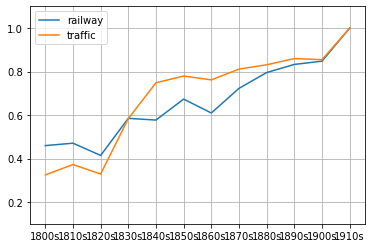

In [12]:
plt.plot(df['timeslice'],df['railway'],label='railway')
plt.plot(df['timeslice'],df['train'],label='traffic')
# plt.plot(file['decade'],file['gear'],label='gear')
plt.ylim([0.1,1.1])
plt.legend()
plt.grid()
# plt.savefig('./outputs/railwaytraffic.png')

### Detect changepoints

Now that we have a `df` containing all cosine similarity scores between timeslices, we can run the `Pelt` algorith from the `rupture` library to detect potential changepoint in the semantic trajectory of each word. We need to define some parameters: 1. the [cost function](https://centre-borelli.github.io/ruptures-docs/code-reference/costs/costl1-reference/) 2. the jump parameter and 3. the penalty. You can read about them in greater detail [here](https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/) and [here](https://centre-borelli.github.io/ruptures-docs/code-reference/detection/pelt-reference/#ruptures.detection.pelt.Pelt). The greater the jump and the penalty, the stricter the detection (the algorithm may only detect changepoints with a very high degree of confidence). Start with the following, then try different parameters to check out their effect yourself:

In [13]:
costfunction = 'l1' # Try also 'l2' and 'rbf'
jump = 1
pen = 0.5

The following will run the `Pelt` algorithm on the `df` and save the output in a CSV where each row is a word (column 1) and the potential changepoints (column 2):

In [14]:
slices = df['timeslice']
changepoints = []

for word in words:
    ts = df[word]
    y = np.array(ts.tolist())
    model = rpt.Pelt(model=costfunction,jump=jump)
    model.fit(y)
    breaks = model.predict(pen=pen)
    print(breaks)
    breaksstr = ''
    for b in breaks:
        if b == len(slices):
            continue
        else:
            breaksstr += str(slices[b-1])
            breaksstr += ' '
    changepoints.append(breaksstr)

changepointsdict = {'words': words, 'changepoints': changepoints}
changepointsdf = pd.DataFrame.from_dict(changepointsdict)

changepointsdf.to_csv(f'./outputs/changepoints-{costfunction}-jump{str(jump)}-pen{str(pen)}.csv',index=False)

[12]
[7, 12]
[3, 12]
[12]
[12]
[7, 12]
[7, 12]
[8, 12]


Have a look at `changepointsdf`:

In [15]:
changepointsdf

,words,changepoints
0,machine,
1,traffic,1860s
2,train,1820s
3,coach,
4,wheel,
5,fellow,1860s
6,railway,1860s
7,match,1870s


If it helps, you can visualize each of the words' trajectories and the detected changepoints, if any:

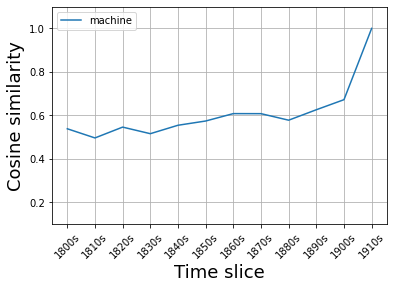

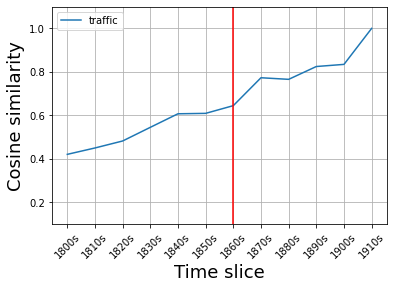

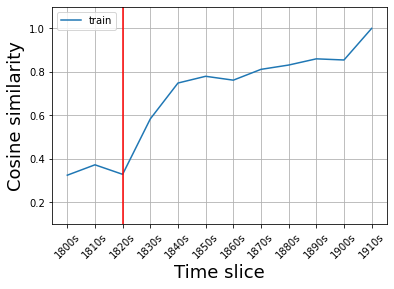

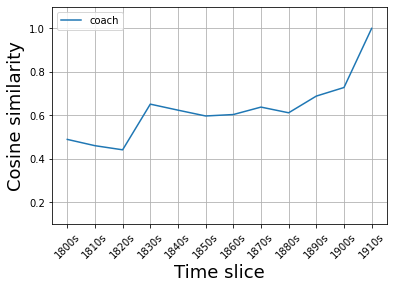

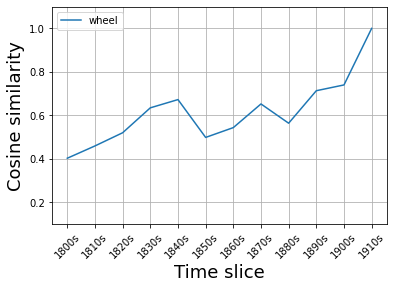

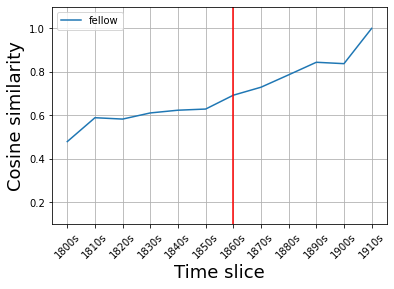

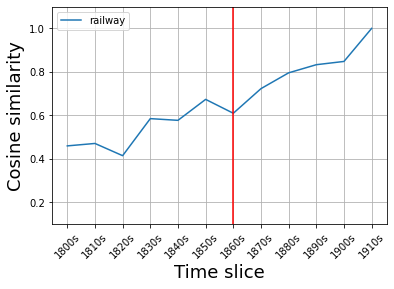

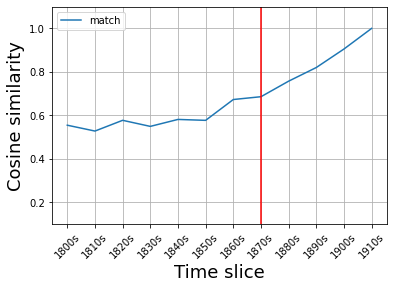

In [18]:
for index, row in changepointsdf.iterrows():
    plt.plot(df['timeslice'],df[row['words']],label=row['words'])
    plt.ylim([0.1,1.1])
    plt.xlabel('Time slice',fontsize=18)
    plt.ylabel('Cosine similarity',fontsize=18)
    for point in row['changepoints'].split():
        plt.axvline(x = point, color = 'r')
    plt.legend()
    plt.grid()
    plt.xticks(rotation = 45)
    plt.show()